In [1]:
#Test for People detection using AlexNet + FC regression model
#Network will output yes or no and bounding box for detection
import numpy as np
import os
import tensorflow as tf
import cv2

In [2]:
#Read in all inputs
#input images and bounding boxes
image_files = os.listdir('images')
labels = os.listdir('xml')

In [3]:
import random
#Lets see a random image
#random.seed(23)
#index = random.randint(0, len(image_files))
index = 3763
img = cv2.imread(os.path.join('images',image_files[index]),1)

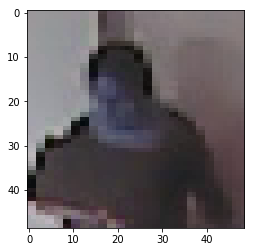

In [4]:
# Will use matplotlib for showing the image
from matplotlib import pyplot as plt

# Plot inline
%matplotlib inline
plt.imshow(img)

In [5]:
#Lets take a look at bounding box label
xml_file = os.path.join('xml',labels[index])
label_file = open(xml_file , 'r')
lines = label_file.read()
print(lines)
label_file.close()

1 7 7 31 32


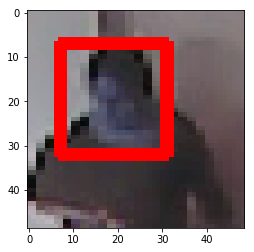

In [6]:
#The format of the label file is 0 x x x x if nothing is present in the image and 1 x0 y0 x1 y1 if there is an object present
#Lets use re to get the coordinates and plot the image
import re
pattern = re.compile(r"(\d+) (\d+) (\d+) (\d+) (\d+)")
matchObj = pattern.findall(lines)
if matchObj:
    is_present = int(matchObj[0][0])
    if is_present == 1:
        x0 = int(matchObj[0][1])
        y0 = int(matchObj[0][2])
        x1 = int(matchObj[0][3])
        y1 = int(matchObj[0][4])
        cv2.rectangle(img,(x0,y0),(x1,y1),(255,0,0),2)
plt.imshow(img)

In [7]:
#Lets us look at total images
print(len(image_files))
print(len(labels))

5880
5880


In [10]:
#Read all these and populate np array
#Read images
allImage = np.zeros([len(image_files),49,49,3])
for i in range(0,len(image_files)):
    img = cv2.imread(os.path.join('images',image_files[i]),1)
    allImage[i]=img
print(allImage.shape)

(5880, 49, 49, 3)


In [12]:
#Read labels and convert to one hot encoded
all_labels = np.zeros([len(labels),6])
import re
for i in range(0,len(labels)):
    label_file = open(os.path.join('xml',labels[i]) , 'r')
    lines = label_file.read()
    label_file.close()
    pattern = re.compile(r"(\d+) (\d+) (\d+) (\d+) (\d+)")
    matchObj = pattern.findall(lines)
    if matchObj:
        is_present = int(matchObj[0][0])
        if is_present == 1:
            not_present = 0
            present = 1            
            x0 = int(matchObj[0][1])
            y0 = int(matchObj[0][2])
            x1 = int(matchObj[0][3])
            y1 = int(matchObj[0][4])
        else:
            not_present = 1
            present = 0        
            x0 = 0
            y0 = 0
            x1 = 0
            y1 = 0
    all_labels[i] = [not_present,present,x0,y0,x1,y1]
print(all_labels.shape)

(5880, 6)


In [15]:
#Test validation split + randomize order
tf.random_shuffle(allImage, seed=181)
tf.random_shuffle(all_labels, seed=181)
import sklearn.model_selection as sk

X_train, X_test, y_train, y_test = sk.train_test_split(allImage,all_labels,test_size=0.20, random_state = 42)

In [16]:
print(len(X_train))
print(len(y_train))

print(len(X_test))
print(len(y_test))

4704
4704
1176
1176


In [17]:
#There are approximate 3000 negatives and 2880 positive images. The images are taken from a 640x480 image and cropped with a 8
#pixel sliding window. If the bounding box is completely encompassed in the 49x49 frame it is stored as label for the image

In [18]:
#Setup tensorflow

#Setup inputs
x = tf.placeholder("float", [None, 49, 49, 3], name='x')#Image
y = tf.placeholder("float", [None, 6], name='y')#Label and boundingbox

#Setup network, using AlexNet as reference with minor changes in first and last layers

############################Layer 1
weight_1 = tf.Variable(tf.truncated_normal([3, 3, 3, 48]))#Kernal size changed from 11 to 3 and stride from 4 to 1        
bias_1 = tf.Variable(tf.zeros(48))

#Apply convolution
conv_layer_1 = tf.nn.conv2d(x, weight_1, strides=[1,1,1,1], padding='VALID')
# Add bias
conv_layer_1 = tf.nn.bias_add(conv_layer_1, bias_1)

# Apply activation function
conv_layer_1 = tf.nn.relu(conv_layer_1)      
conv_layer_1 = tf.nn.max_pool(conv_layer_1,ksize=[1,3,3,1],strides=[1,2,2,1],padding='VALID')

print(conv_layer_1.get_shape())
#############################Layer 2
weight_2 = tf.Variable(tf.truncated_normal([5, 5, 48, 128]))
bias_2 = tf.Variable(tf.zeros(128))

#Apply convolution
conv_layer_2 = tf.nn.conv2d(conv_layer_1, weight_2, strides=[1,1,1,1], padding='VALID')
# Add bias
conv_layer_2 = tf.nn.bias_add(conv_layer_2, bias_2)

# Apply activation function
conv_layer_2 = tf.nn.relu(conv_layer_2)      
conv_layer_2 = tf.nn.max_pool(conv_layer_2,ksize=[1,3,3,1],strides=[1,2,2,1],padding='VALID')

print(conv_layer_2.get_shape())
#############################Layer 3
weight_3 = tf.Variable(tf.truncated_normal([3, 3, 128, 192]))
bias_3 = tf.Variable(tf.zeros(192))

#Apply convolution
conv_layer_3 = tf.nn.conv2d(conv_layer_2, weight_3, strides=[1,1,1,1], padding='VALID')
# Add bias
conv_layer_3 = tf.nn.bias_add(conv_layer_3, bias_3)
# Apply activation function
conv_layer_3 = tf.nn.relu(conv_layer_3)      

print(conv_layer_3.get_shape())

weight_4 = tf.Variable(tf.truncated_normal([3, 3, 192, 192]))
bias_4 = tf.Variable(tf.zeros(192))

#Apply convolution
conv_layer_3 = tf.nn.conv2d(conv_layer_3, weight_4, strides=[1,1,1,1], padding='VALID')
# Add bias
conv_layer_3 = tf.nn.bias_add(conv_layer_3, bias_4)
# Apply activation function
conv_layer_3 = tf.nn.relu(conv_layer_3)      

print(conv_layer_3.get_shape())

weight_5 = tf.Variable(tf.truncated_normal([3, 3, 192, 128]))
bias_5 = tf.Variable(tf.zeros(128))

#Apply convolution
conv_layer_3 = tf.nn.conv2d(conv_layer_3, weight_5, strides=[1,1,1,1], padding='VALID')
# Add bias
conv_layer_3 = tf.nn.bias_add(conv_layer_3, bias_5)
# Apply activation function
conv_layer_3 = tf.nn.relu(conv_layer_3)  

conv_layer_3 = tf.nn.max_pool(conv_layer_3,ksize=[1,3,3,1],strides=[1,2,2,1],padding='VALID')

print(conv_layer_3.get_shape())
#############################Layer 4
dim = conv_layer_3.get_shape().as_list()  
fc_1 = tf.reshape(conv_layer_3, [-1,dim[1]*dim[2]*dim[3]])     

dim = fc_1.get_shape().as_list()  
fc_weight_1 = tf.Variable(tf.truncated_normal([dim[1], 2048]))        
fc_bias_1 = tf.Variable(tf.zeros(2048))
    
# Apply multiplication        
fc_layer_1 = tf.matmul(fc_1, fc_weight_1)
# Add bias
fc_layer_1 = tf.nn.bias_add(fc_layer_1, fc_bias_1)
# Apply activation function
fc_layer_1 = tf.nn.relu(fc_layer_1)          

print(fc_layer_1.get_shape())
#############################Layer 5
dim = fc_layer_1.get_shape().as_list()  
fc_weight_2 = tf.Variable(tf.truncated_normal([dim[1], 2048]))        
fc_bias_2 = tf.Variable(tf.zeros(2048))
    
# Apply multiplication        
fc_layer_2 = tf.matmul(fc_layer_1, fc_weight_2)
# Add bias
fc_layer_2 = tf.nn.bias_add(fc_layer_2, fc_bias_2)
# Apply activation function
fc_layer_2 = tf.nn.relu(fc_layer_2)          

print(fc_layer_2.get_shape())
#############################Layer 6
#Output label and bounding box
dim = fc_layer_2.get_shape().as_list()  
fc_weight_3 = tf.Variable(tf.truncated_normal([dim[1], 6]))        
fc_bias_3 = tf.Variable(tf.zeros(6))
# Apply multiplication        
fc_layer_3 = tf.matmul(fc_layer_2, fc_weight_3)
# Add bias
output_layer = tf.nn.bias_add(fc_layer_3, fc_bias_3)

print(output_layer.get_shape())

(?, 23, 23, 48)
(?, 9, 9, 128)
(?, 7, 7, 192)
(?, 5, 5, 192)
(?, 1, 1, 128)
(?, 2048)
(?, 2048)
(?, 6)


In [44]:
#define loss
is_present = output_layer[:,0:2] 
bounding_box_coordinates = output_layer[:,2:]
print(is_present.get_shape())
print(bounding_box_coordinates.get_shape())
print(y[:,2:].get_shape())

(?, 2)
(?, 4)
(?, 4)


In [45]:
def bbox_overlap_iou(bboxes1, bboxes2):
    """
    Args:
        bboxes1: shape (total_bboxes1, 4)
            with x1, y1, x2, y2 point order.
        bboxes2: shape (total_bboxes2, 4)
            with x1, y1, x2, y2 point order.
        p1 *-----
           |     |
           |_____* p2
    Returns:
        Tensor with shape (total_bboxes1, total_bboxes2)
        with the IoU (intersection over union) of bboxes1[i] and bboxes2[j]
        in [i, j].
    """

    x11 = bboxes1[:,0]
    y11 = bboxes1[:,1]
    x12 = bboxes1[:,2]
    y12 = bboxes1[:,3]
    
    x21 = bboxes2[:,0]
    y21 = bboxes2[:,1]
    x22 = bboxes2[:,2]
    y22 = bboxes2[:,3]

    #x11, y11, x12, y12 = tf.split(bboxes1, 4, axis=1)
    #x21, y21, x22, y22 = tf.split(bboxes2, 4, axis=1)

    xI1 = tf.maximum(x11, x21)
    yI1 = tf.maximum(y11, y21)

    xI2 = tf.minimum(x12, x22)
    yI2 = tf.minimum(y12, y22)

    inter_area = (xI2 - xI1 + 1) * (yI2 - yI1 + 1)

    bboxes1_area = (x12 - x11 + 1) * (y12 - y11 + 1)
    bboxes2_area = (x22 - x21 + 1) * (y22 - y21 + 1)

    union = (bboxes1_area + tf.transpose(bboxes2_area)) - inter_area

    return tf.maximum(inter_area / union, 0)

In [46]:
#dim = is_prediction_present.get_shape().as_list() 
#l1 = tf.constant(0,shape=[dim[0], 1])
#l0 = tf.mult(bbox_loss,0)
#print(l0.get_shape())
#print(l1.get_shape())
#b = tf.cond(is_prediction_present, lambda: tf.constant(10), lambda: tf.constant(0))
#iou_loss = tf.cond(prediction[:,0] < prediction[:,1], lambda: bbox_overlap_iou(bounding_box_coordinates,y[:,1:]), lambda: 0)

In [47]:
#calculate cross entropy loss
cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=is_present, labels=y[:,:2]))

#calculate loss only is prediction says person is present 2nd column > 1st column
prediction = tf.nn.softmax(is_present)
is_prediction_present = tf.less_equal(prediction[:,0],prediction[:,1])    
print(is_prediction_present.get_shape())

bbox_loss = bbox_overlap_iou(bounding_box_coordinates,y[:,1:])
print(bbox_loss.get_shape())

l0 = tf.zeros_like(bbox_loss)
print(l0.get_shape())

#if prediction is present calculate iou loss, else return 0
iou_loss = tf.reduce_mean(tf.where(is_prediction_present,bbox_loss,l0))

(?,)
(?,)
(?,)


In [48]:
#add weights to cross entropy and iou losses

alpha = 1.0
total_loss = alpha * cross_entropy_loss + (1 - alpha) * iou_loss
optimizer = tf.train.AdamOptimizer().minimize(total_loss)

In [49]:
# Accuracy
correct_pred = tf.equal(tf.argmax(is_present, 1), tf.argmax(y[:,:2], 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')


In [50]:
def train_neural_network(session, optimizer,feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    # TODO: Implement Function
    session.run(optimizer, feed_dict={
                x: feature_batch,
                y: label_batch})
    pass



In [51]:
def print_stats(session, feature_batch, label_batch, valid_features, valid_labels, total_loss, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    # TODO: Implement Function
    loss = session.run(total_loss, feed_dict={
                       x: feature_batch,
                       y: label_batch})
    acc = session.run(accuracy, feed_dict={
                       x: valid_features,
                       y: valid_labels})
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss,acc))
    pass

In [52]:
# TODO: Tune Parameters
epochs = 100
batch_size = 512

In [53]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [54]:
for i in range(0, int(np.ceil(len(X_train)/batch_size))):
    start_index = i*batch_size
    end_index = min(i*batch_size+(batch_size-1),len(X_train))
    print(start_index,end_index)

0 511
512 1023
1024 1535
1536 2047
2048 2559
2560 3071
3072 3583
3584 4095
4096 4607
4608 4704


In [55]:
for epoch in range(epochs):
    for i in range(0, int(np.ceil(len(X_train)/batch_size))):
        start_index = i*batch_size
        end_index = min(i*batch_size+(batch_size-1),len(X_train))
        batch_features = X_train[start_index:end_index]
        batch_labels = y_train[start_index:end_index]            
        train_neural_network(sess, optimizer, batch_features, batch_labels)
        print('Epoch {:>2}, Batch {}:  '.format(epoch + 1, i), end='')
        print_stats(sess, batch_features, batch_labels, X_test, y_test, total_loss, accuracy)

Epoch  1, Batch 0:  Loss:        nan Validation Accuracy: 0.478741
Epoch  1, Batch 1:  Loss:        nan Validation Accuracy: 0.521259
Epoch  1, Batch 2:  Loss:        nan Validation Accuracy: 0.521259
Epoch  1, Batch 3:  Loss:        nan Validation Accuracy: 0.521259
Epoch  1, Batch 4:  Loss:        nan Validation Accuracy: 0.521259
Epoch  1, Batch 5:  Loss:        nan Validation Accuracy: 0.521259
Epoch  1, Batch 6:  Loss:        nan Validation Accuracy: 0.521259
Epoch  1, Batch 7:  Loss:        nan Validation Accuracy: 0.521259
Epoch  1, Batch 8:  Loss:        nan Validation Accuracy: 0.521259
Epoch  1, Batch 9:  Loss:        nan Validation Accuracy: 0.521259
Epoch  2, Batch 0:  Loss:        nan Validation Accuracy: 0.521259
Epoch  2, Batch 1:  Loss:        nan Validation Accuracy: 0.521259
Epoch  2, Batch 2:  Loss:        nan Validation Accuracy: 0.521259
Epoch  2, Batch 3:  Loss:        nan Validation Accuracy: 0.521259
Epoch  2, Batch 4:  Loss:        nan Validation Accuracy: 0.52

KeyboardInterrupt: 